# Evaluación de predicciones en diferentes periodos de tiempo

Lo que se realiza a continuación se trata del pronóstico realizado para diferentes periodos de tiempo a futuro acompañado de las medidas de evaluación antes empleadas. Con ejercer esta nueva medida se intenta respaldar la hipótesis: las estaciones que se encuentran dentro de la distribución del head en la diversidad de rango tienen un comportamiento más predecible sobre aquellas que ocupan la región del body y por ende, deben de tener un menor error.

En este notebook se utilizó un conjunto de entrenamiento reducido con respecto al anterior, utilizando solo desde mayo del 2012 a octubre del mismo año, lo anterior con el objetivo de reducir la variabilidad con respecto a los primeros 2 años de registros registrados. También se agregó una nueva medida de evaluación para los pronósticos realizados entre los resultados observados conocido como RMSE (Root Mean Square Error).

Lo que a continuación se presenta son las tablas con la evaluación obtenida para cada modelo para 1, 5 y 18 horas incluyendo ahora el RMSE.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns; sns.set()
import datetime as dt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 18, 10

In [2]:
import statsmodels.api as sm
import rpy2.robjects as R
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()

In [3]:
k_3 = pd.read_csv(r'C:\Users\ghost\Desktop\pruebas\ECOBICI_data\Consensus cluster\Datos_no_normalizados\fase 1\cluster_member3.csv')
res = pd.read_csv(r'C:\Users\ghost\Desktop\pruebas\ECOBICI_data\Consensus cluster\Datos_no_normalizados\phase1_no_normalized.csv').T

In [4]:
res['cluster'] = k_3.values
temp_res = res.sort_values(['cluster'])

In [5]:
path = "D:\ownCloud\Documentos posgrado\Posgrado 2do semestre\Seminario investigacion\Experimental Data\Cd Mex\Movilidad\Hist Ecobici\ecobici.csv"
trips = pd.read_csv(path,
                    parse_dates=['date_removed', 'date_arrived'],
                    infer_datetime_format=True,
                    low_memory=False)

# Find the start date
ind = pd.DatetimeIndex(trips.date_arrived)
trips['date'] = ind.date.astype('datetime64')
trips['hour'] = ind.hour

trips = trips.loc[trips['action'] != 'C  ']

idx = pd.date_range(trips.date.min(), trips.date.max() + dt.timedelta(days=1), freq='H')

by_hour = (trips
     .set_index('date_arrived')
     .groupby([pd.TimeGrouper('H'), 'station_arrived'])
     .station_arrived
     .count()
     .unstack()
     .reindex(idx)
     .fillna(0)
     )
# Delete activity of non existent station's IDs in the dataset
by_hour.drop([col for col in list(by_hour.columns.values) if col > 275], axis=1, inplace=True)

# Keep only weekdays to make a more stable count signal
by_hour = by_hour[by_hour.index.dayofweek < 5]

# Since the system's opening, the slow activity of the first days were removed
#by_hour = by_hour['2010-03-01':'2012-10-29']
by_hour = by_hour['2012-05-01':'2012-10-29']

# Keep business hours for the system. Ecobici closes from 0:00 to 5:00
by_hour = by_hour.between_time('6:00','23:00')

In [6]:
logged_ts = by_hour + 1
logged_ts = logged_ts.apply(np.log)

# deal with missing values.
logged_ts.interpolate(inplace=True)

In [7]:
head = temp_res[temp_res.cluster == 1]
body = temp_res[temp_res.cluster == 2].sample(10)
tail = temp_res[temp_res.cluster == 3]

sub_sample = pd.concat([head,body,tail])

In [8]:
%load_ext rpy2.ipython

In [9]:
stats = importr('stats')
tseries = importr('tseries')
forecast = importr('forecast')

In [10]:
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import rmse

In [11]:
def SARIMA_forecast(train, test, sub_sample):
    order = R.IntVector((0,1,1))
    season = R.ListVector({'order': R.IntVector((0,1,1)), 'period' : 18})

    columns = ['AIC','Durbin-Watson','RSS train','Unit root','Mean Absolute Error','RMSE']
    df_ = pd.DataFrame(index = sub_sample.index.astype(int),columns=columns)
    df_ = df_.fillna(0) # with 0s rather than NaNs

    forecast_matrix = pd.DataFrame(index = test.index, columns=sub_sample.index.astype(int))
    forecast_matrix = forecast_matrix.fillna(0)

    #arima_models = []

    for i in sub_sample.index.astype(int):
        r_df = pandas2ri.py2ri(train[[i]])
        y = stats.ts(r_df)
        model = stats.arima(y, order = order, seasonal=season)

        %Rpush model
        AIC = R.r('model$aic')[0]
        durbin_watson = sm.stats.durbin_watson(R.r('model$residuals'))
        RSS = sum((train[[i]].values-R.r('fitted(model)'))**2)
        unit_root = sum(R.r('model$coef'))

        f = forecast.forecast(model,len(test))
        pred = [j[1] for j in f[3].items()]
        dt = test.index
        pr = pd.Series(pred, index = dt)
        mae = mean_absolute_error(test[i],pr)
        rms = rmse(test[i],pr)
        forecast_matrix[i] = pred

        df_.loc[i] = [AIC, durbin_watson, RSS, unit_root, mae, rms]
        #arima_models.append(model)
    return df_

## 1 Hour forecast

In [12]:
test = logged_ts.last('1H')

train = logged_ts
train = train.drop(test.index)

In [13]:
df1_ = SARIMA_forecast(train, test, sub_sample)

In [14]:
df1_

,AIC,Durbin-Watson,RSS train,Unit root,Mean Absolute Error,RMSE
1,2670.968610,1.727982,420.997818,-1.878459,0.268241,0.268241
64,2909.517337,1.763387,466.158198,-1.659746,0.312145,0.312145
27,3174.425281,1.783284,519.634590,-1.804414,0.321168,0.321168
36,2573.261965,1.777523,403.807953,-1.827199,0.376011,0.376011
13,3939.378686,1.727363,728.309564,-1.705885,0.224105,0.224105
42,3523.405495,1.842209,606.246060,-1.934615,0.458710,0.458710
46,3463.719775,1.807874,592.298413,-1.793267,0.625740,0.625740
57,3079.453414,1.916786,499.546248,-1.947266,0.469110,0.469110
61,3222.826775,1.810343,532.520352,-1.843890,0.020064,0.020064
50,3125.365703,1.935418,509.471533,-1.949667,0.479264,0.479264


*Es de notarse que el RMSE tiene un parecido idéntico con el MAE para este, esto es debido a que solo se utiliza un dato para realizar la evaluación.

## 5 Hours forecast

In [15]:
test = logged_ts.last('5H')

train = logged_ts
train = train.drop(test.index)

In [16]:
df5_ = SARIMA_forecast(train, test, sub_sample)

In [17]:
df5_

,AIC,Durbin-Watson,RSS train,Unit root,Mean Absolute Error,RMSE
1,2666.688400,1.729616,420.346794,-1.876926,0.306134,0.387186
64,2906.887771,1.763042,465.870197,-1.658664,0.348089,0.386024
27,3164.266176,1.784438,517.750079,-1.802587,0.474637,0.628995
36,2569.601933,1.775602,403.218517,-1.828810,0.358267,0.394830
13,3930.697594,1.726465,726.464296,-1.704144,0.398103,0.554326
42,3519.274715,1.842964,605.632180,-1.935241,0.326798,0.392146
46,3461.450346,1.807654,592.204403,-1.793194,0.269977,0.354057
57,3075.009418,1.916447,498.841221,-1.947278,0.388451,0.425646
61,3217.182439,1.811962,531.501567,-1.843886,0.347206,0.424710
50,3122.769428,1.936266,509.161092,-1.949874,0.279248,0.320730


## 18 Hours forecast

In [18]:
test = logged_ts.last('18H')

train = logged_ts
train = train.drop(test.index)

In [19]:
df18_ = SARIMA_forecast(train, test, sub_sample)

In [20]:
df18_

,AIC,Durbin-Watson,RSS train,Unit root,Mean Absolute Error,RMSE
1,2635.736428,1.728025,415.106073,-1.875793,0.440901,0.586277
64,2873.251831,1.765200,459.851916,-1.653535,0.386882,0.549706
27,3135.433850,1.792649,512.036174,-1.803944,0.492093,0.613913
36,2535.862976,1.774413,397.521077,-1.828924,0.445038,0.582560
13,3898.134559,1.728887,719.242489,-1.700279,0.731817,0.809339
42,3502.742028,1.845430,603.111821,-1.933752,0.370959,0.434852
46,3439.679448,1.810706,588.236977,-1.792168,0.411430,0.543205
57,3056.327794,1.921399,495.409125,-1.949933,0.379332,0.477579
61,3198.534361,1.814723,528.293766,-1.843560,0.375216,0.460805
50,3098.324555,1.947042,504.613105,-1.950823,0.400795,0.526810


[<matplotlib.text.Text at 0x9a1a4400>, <matplotlib.text.Text at 0x9a19fac8>]

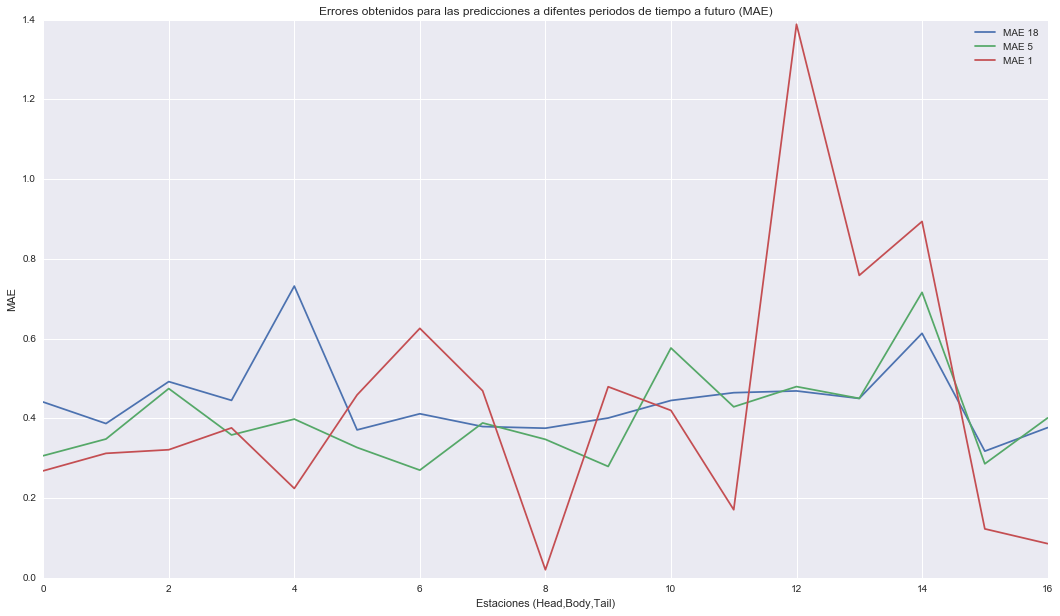

In [21]:
aux = pd.concat([df18_['Mean Absolute Error'], df5_['Mean Absolute Error'], df1_['Mean Absolute Error']], axis=1)
aux.columns = ["MAE 18","MAE 5","MAE 1"]
aux = aux.reset_index()
del aux['index']

ax = aux.plot(title='Errores obtenidos para las predicciones a difentes periodos de tiempo a futuro (MAE)',)
ax.set(xlabel="Estaciones (Head,Body,Tail)", ylabel="MAE")

[<matplotlib.text.Text at 0x932f09b0>, <matplotlib.text.Text at 0x9b17cef0>]

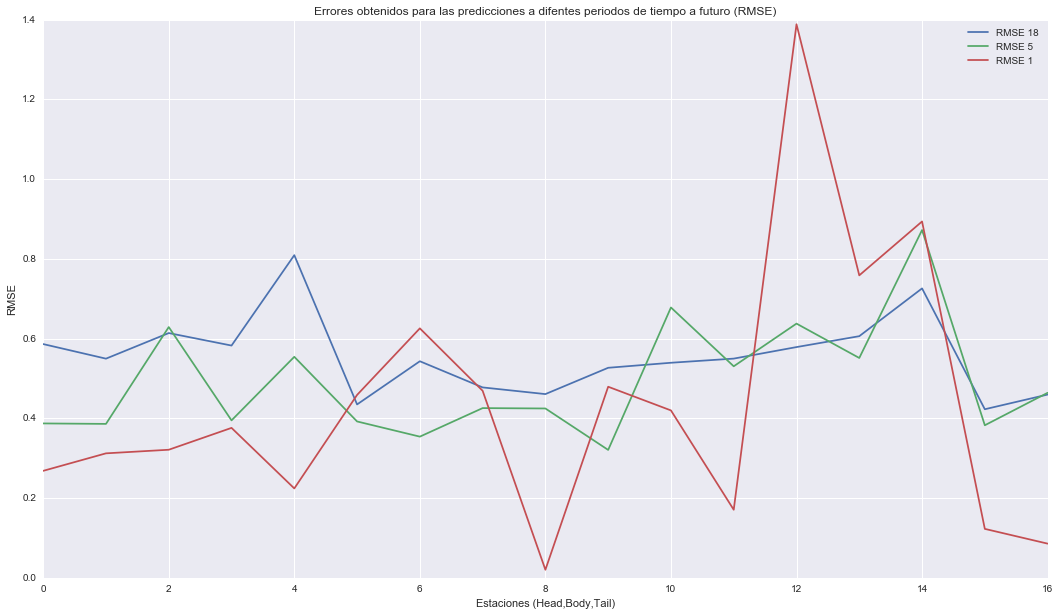

In [23]:
aux = pd.concat([df18_['RMSE'], df5_['RMSE'], df1_['RMSE']], axis=1)
aux.columns = ["RMSE 18","RMSE 5","RMSE 1"]
aux = aux.reset_index()
del aux['index']

ax = aux.plot(title='Errores obtenidos para las predicciones a difentes periodos de tiempo a futuro (RMSE)',)
ax.set(xlabel="Estaciones (Head,Body,Tail)", ylabel="RMSE")

Tras observar el gráfico se notan los diferentes comportamientos:
- El error obtenido es mucho más variable en el body cuando la predicción es a corto plazo, ésto debido al número de muestras.
- Algunas estaciones en el body obtienen un MAE menor que las estaciones del head y tail en algunas situaciones.
- Las predicciones de 5 y 18 horas en el futuro no presentan una mejora notable con respecto a 

La evidencia anterior no parece no respaldar la hipótesis. Todo parece indicar que la predictibilidad de la estación tomando en cuenta el lugar que ocupa la estación en la distribución de diversidad de rango no parace mejorar según su posición.

In [24]:
from IPython.display import HTML
#To hide code from the nbviewer render
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')